# LSTM Model with Checkpoints

## Introduction
This notebook demonstrates how to build an LSTM (Long Short-Term Memory) model for emotion recognition from speech. We will load audio data, preprocess it, and train an LSTM model while saving checkpoints for the best performing model during training.

In [ ]:
# Download dataset from kaggle
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

# Unzip downloaded dataset
!unzip toronto-emotional-speech-set-tess.zip

# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import os  # For interacting with the operating system
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns  # For data visualization
import matplotlib.pyplot as plt  # For plotting graphs
import librosa  # For audio processing
import librosa.display  # For displaying audio signals
from IPython.display import Audio  # For audio playback in the notebook
from sklearn.preprocessing import OneHotEncoder

import warnings  # To manage warning messages
warnings.filterwarnings('ignore')  # Ignore warnings for cleaner output

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

## Load Dataset

In [ ]:
# Initialize lists to store file paths and labels
paths = []
labels = []

# Traverse the dataset directory to load audio files and their respective labels
for dirname, _, filenames in os.walk('/content/tess toronto emotional speech set data'):
    for filename in filenames:
        paths.append(os.path.join(dirname, filename))  # Store the full path of the audio file
        label = filename.split('_')[-1].split('.')[0].lower()  # Extract the label from the filename
        labels.append(label)  # Store the label
    if len(paths) == 2800:  # Break if we have loaded all files
        break

print('Dataset is Loaded')

Dataset is Loaded


### Explanation
- We use `os.walk` to traverse the directory containing the audio files.
- Each audio file's path and label are extracted and stored in lists.
- The dataset consists of 2800 audio files, categorized by emotion.

In [ ]:
# Check the number of loaded audio files
len(paths)

2800

## Preview of Loaded Data

In [ ]:
# Display the first 5 paths and their corresponding labels
print(paths[:5])
print("--------------------------------------------------")
print(labels[:5])

['/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_tire_fear.wav', '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_kill_fear.wav', '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_fail_fear.wav', '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_calm_fear.wav', '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_far_fear.wav']
--------------------------------------------------
['fear', 'fear', 'fear', 'fear', 'fear']


## Create DataFrame

In [ ]:
# Create a DataFrame from the paths and labels
df = pd.DataFrame()
df['speech'] = paths
df['label'] = labels
df.head()  # Display the first few rows of the DataFrame

,speech,label
0,/content/tess toronto emotional speech set dat...,fear
1,/content/tess toronto emotional speech set dat...,fear
2,/content/tess toronto emotional speech set dat...,fear
3,/content/tess toronto emotional speech set dat...,fear
4,/content/tess toronto emotional speech set dat...,fear


## Data Distribution

In [ ]:
# Check the distribution of labels
label_counts = df['label'].value_counts()
print(label_counts)

label
fear       400
ps         400
disgust    400
sad        400
angry      400
happy      400
neutral    400
Name: count, dtype: int64


## Data Visualization

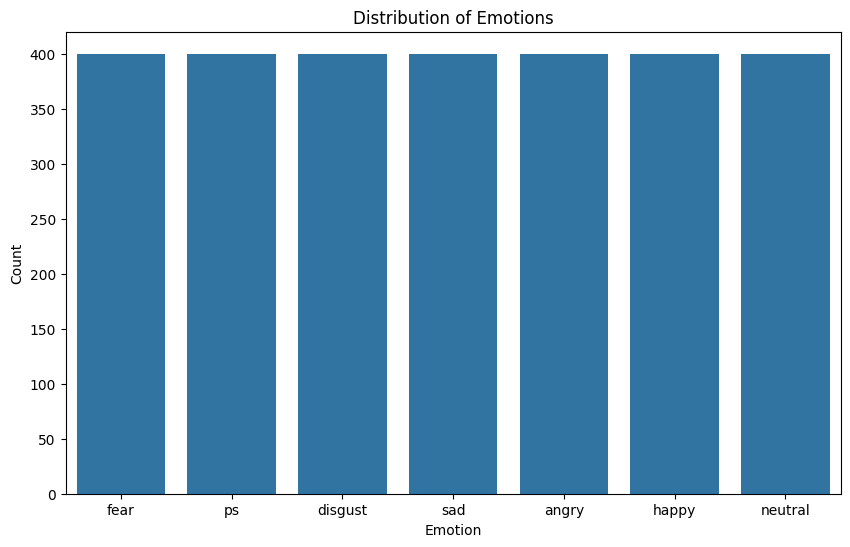

In [ ]:
# Plot the distribution of emotions
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='label')
plt.title('Distribution of Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show();

In [ ]:
# Function to plot the waveform of an audio signal
def waveplot(data, sr, emotion):
    # Create a new figure with specified size
    plt.figure(figsize=[10, 4])
    # Set the title of the plot to the given emotion
    plt.title(emotion, size=20)
    # Display the waveform using librosa's waveshow function
    librosa.display.waveshow(data, sr=sr)
    # Show the plot
    plt.show()

# Function to plot the spectrogram of an audio signal
def spectogram(data, sr, emotion):
    # Compute the Short-Time Fourier Transform (STFT) of the audio data
    x = librosa.stft(data)
    # Convert the amplitude of the STFT to decibels
    xdb = librosa.amplitude_to_db(abs(x))
    # Create a new figure with specified size
    plt.figure(figsize=(11, 4))
    # Set the title of the plot to the given emotion
    plt.title(emotion, size=20)
    # Display the spectrogram using librosa's specshow function
    librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz')
    # Add a color bar to indicate the scale of the spectrogram
    plt.colorbar()

In [ ]:
# Print the first few rows of the DataFrame to check the loaded data
print(df.head())
print("----------------------------------------------------")
# Print the unique emotion labels present in the DataFrame
print(df['label'].unique())

                                              speech label
0  /content/tess toronto emotional speech set dat...  fear
1  /content/tess toronto emotional speech set dat...  fear
2  /content/tess toronto emotional speech set dat...  fear
3  /content/tess toronto emotional speech set dat...  fear
4  /content/tess toronto emotional speech set dat...  fear
----------------------------------------------------
['fear' 'ps' 'disgust' 'sad' 'angry' 'happy' 'neutral']


In [ ]:
# Check the unique audio file paths in the DataFrame
df['speech'].unique()

array(['/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_tire_fear.wav',
       '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_kill_fear.wav',
       '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/OAF_Fear/OAF_fail_fear.wav',
       ...,
       '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_long_ps.wav',
       '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_burn_ps.wav',
       '/content/tess toronto emotional speech set data/TESS Toronto emotional speech set data/YAF_pleasant_surprised/YAF_mood_ps.wav'],
      dtype=object)

## Implementing `waveplot` and `spectogram` functions created above

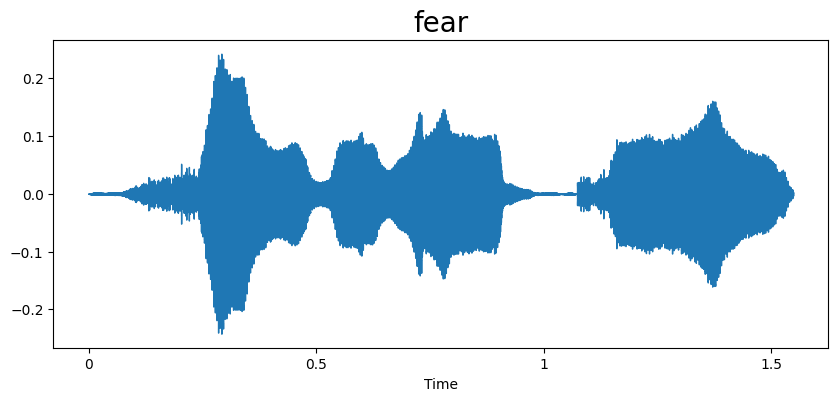

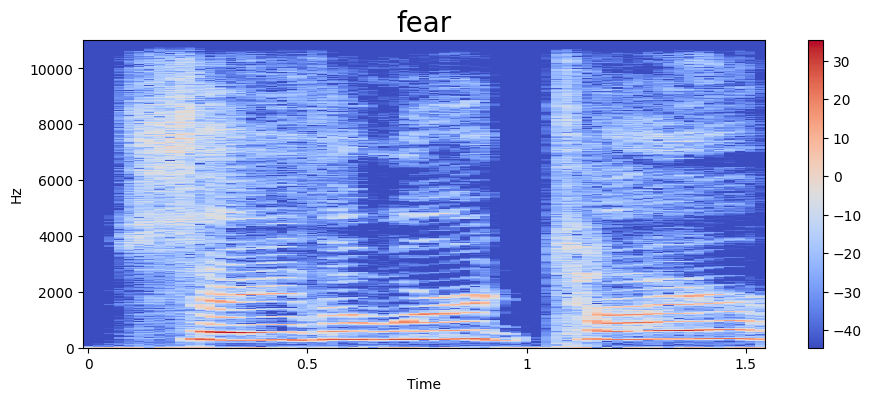

In [ ]:
# Select a specific emotion for visualization
emotion = 'fear'

# Extract the path of the first audio file associated with the specified emotion
path = np.array(df['speech'][df['label'] == emotion])[0]

# Load the audio file using librosa
data, sampling_rate = librosa.load(path)

# Call the waveplot function to visualize the audio waveform
waveplot(data, sampling_rate, emotion)

# Call the spectogram function to visualize the spectrogram of the audio
spectogram(data, sampling_rate, emotion)

# Play the audio file in the notebook
Audio(path)

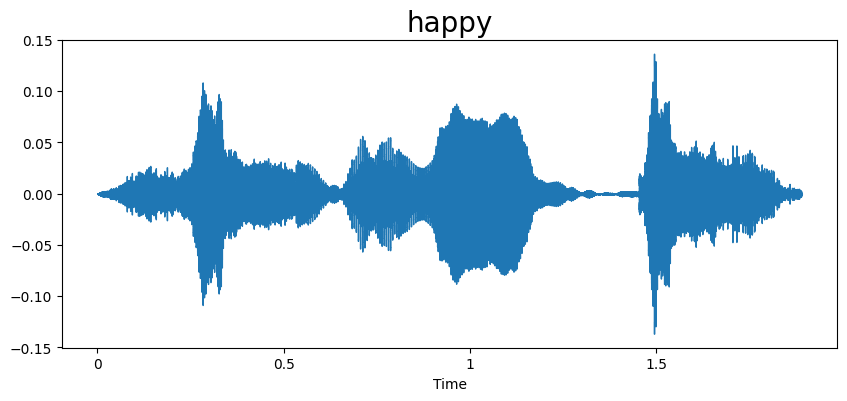

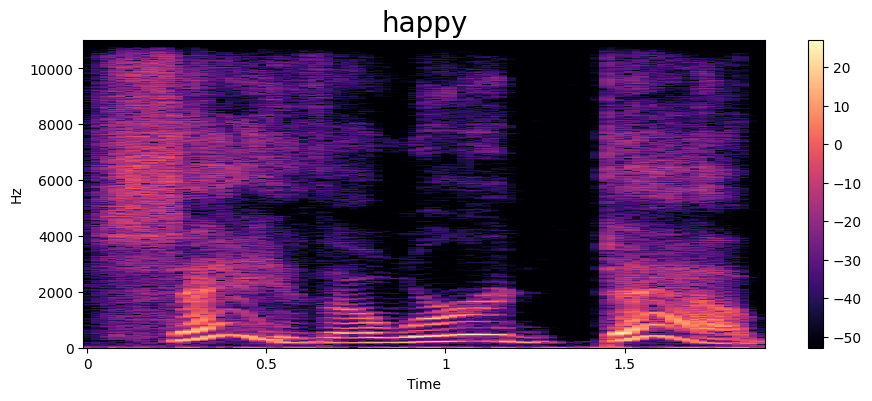

In [ ]:
# Select a specific emotion for visualization
emotion = 'happy'

# Extract the path of the first audio file associated with the specified emotion
path = np.array(df['speech'][df['label'] == emotion])[0]

# Load the audio file using librosa
data, sampling_rate = librosa.load(path)

# Call the waveplot function to visualize the audio waveform
waveplot(data, sampling_rate, emotion)

# Call the spectogram function to visualize the spectrogram of the audio
spectogram(data, sampling_rate, emotion)

# Play the audio file in the notebook
Audio(path)

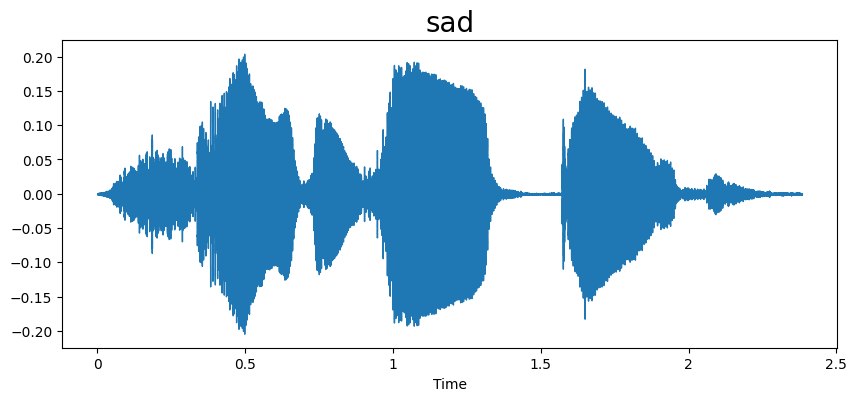

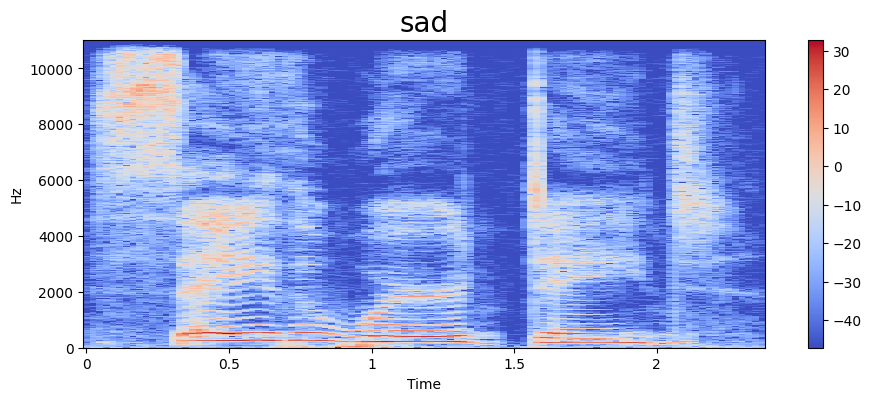

In [ ]:
# Select a specific emotion for visualization
emotion = 'sad'

# Extract the path of the first audio file associated with the specified emotion
path = np.array(df['speech'][df['label'] == emotion])[0]

# Load the audio file using librosa
data, sampling_rate = librosa.load(path)

# Call the waveplot function to visualize the audio waveform
waveplot(data, sampling_rate, emotion)

# Call the spectogram function to visualize the spectrogram of the audio
spectogram(data, sampling_rate, emotion)

# Play the audio file in the notebook
Audio(path)

***Test the visualisation code above on other emotions***

## Audio Feature Extraction

In [ ]:
# Function to extract features from audio files
def extract_features(file_path):
    audio, sample_rate = librosa.load(file_path, duration=3, offset=0.5)  # Load audio file
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  # Extract MFCC features
    return np.mean(mfccs.T, axis=0)  # Return mean of MFCCs across time

# Extract features for all audio files
features = np.array([extract_features(path) for path in paths])

### Explanation
- The `extract_features` function processes an audio file by loading it, extracting its MFCC features, and returning the mean MFCCs across time.
- The second part of the code extracts these features for all audio files in the list `paths` and stores them in a NumPy array `features`, where each row corresponds to the feature vector for one audio file.

### Note:
- **MFCC (Mel Frequency Cepstral Coefficients)** are extracted as they are commonly used features for audio classification tasks.

In [ ]:
# Convert the DataFrame to a format suitable for LSTM

# Get Features and convert
X = np.expand_dims(features, -1)

# Get Target and convert
enc = OneHotEncoder()    # Instantiate one-hot encoder
y = enc.fit_transform(df[['label']].values.reshape(-1, 1)).toarray()    # One-hot encode labels

In [ ]:
print(X.shape)
print("--------------------------")
print(X[0][0:5]) # Prints the first 5 features of the first audio file
print("--------------------------")
print(y.shape)
print("--------------------------")
print(y[0:4]) # Prints the emotion of the first 4 audio file

(2800, 40, 1)
--------------------------
[[-388.4847    ]
 [  85.04311   ]
 [   0.86716884]
 [ -27.837967  ]
 [  -8.867706  ]]
--------------------------
(2800, 7)
--------------------------
[[0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]


## Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Explanation
- The dataset is split into training (80%) and validation (20%) sets to evaluate the model's performance.

In [ ]:
# Build LSTM Model
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

# Define the model
model = Sequential()
model.add(LSTM(512, input_shape=(40, 1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(256))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(7, activation='softmax'))  # Output layer

## Compile the Model

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

### Explanation
- The model is compiled with the categorical crossentropy loss function, suitable for multi-class classification.

In [ ]:
# Model Training with Checkpoints
from keras.callbacks import ModelCheckpoint

# Define a callback to save the best model
filepath = 'model_epoch_{epoch:02d}_val_acc_{val_accuracy:.2f}.keras'
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=50, batch_size=64, callbacks=[checkpoint])

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3377 - loss: 1.6667
Epoch 1: val_accuracy improved from -inf to 0.61161, saving model to model_epoch_01_val_acc_0.61.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.3415 - loss: 1.6589 - val_accuracy: 0.6116 - val_loss: 0.9272
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6677 - loss: 0.8519
Epoch 2: val_accuracy improved from 0.61161 to 0.80357, saving model to model_epoch_02_val_acc_0.80.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6691 - loss: 0.8488 - val_accuracy: 0.8036 - val_loss: 0.5863
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7981 - loss: 0.6129
Epoch 3: val_accuracy improved from 0.80357 to 0.83482, saving model to model_epoch_03_val_acc_0.83.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.7985 - loss: 0.6110 - val_accuracy: 0.8348 - val_loss: 0.4826
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8666 - loss: 0.4119
Epoch 4:

In [ ]:
# Load the best model from the checkpoint file
from keras.models import load_model


best_model = load_model('model_epoch_29_val_acc_0.99.keras')

### Explanation
- The model is trained, and checkpoints are saved for the best validation accuracy.

In [25]:
# Generate predictions on the test set
y_pred = best_model.predict(X_test)

# Convert predictions from probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(y_test, axis=1)

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 223ms/step


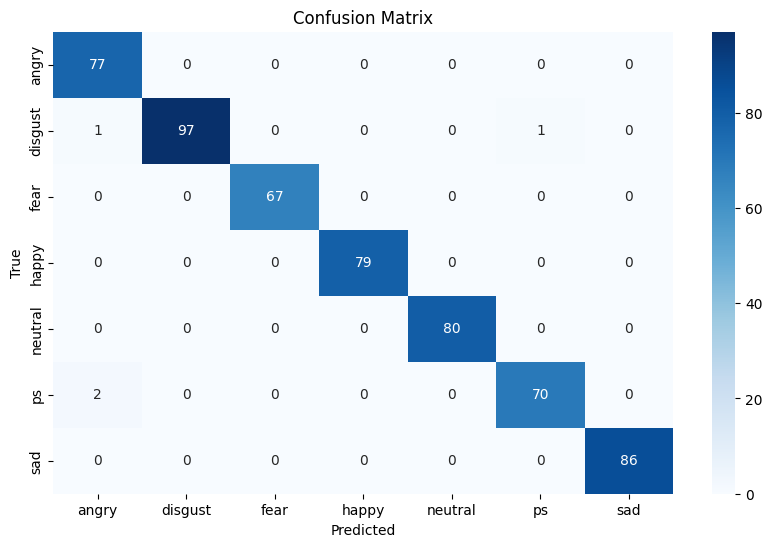

In [26]:
from sklearn.metrics import confusion_matrix, classification_report

# Create a confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [27]:
# Generate the classification report
report = classification_report(y_true, y_pred_classes, target_names=np.unique(labels))
print(report)

              precision    recall  f1-score   support

       angry       0.96      1.00      0.98        77
     disgust       1.00      0.98      0.99        99
        fear       1.00      1.00      1.00        67
       happy       1.00      1.00      1.00        79
     neutral       1.00      1.00      1.00        80
          ps       0.99      0.97      0.98        72
         sad       1.00      1.00      1.00        86

    accuracy                           0.99       560
   macro avg       0.99      0.99      0.99       560
weighted avg       0.99      0.99      0.99       560



In [28]:
# Evaluate the Model
# Evaluate the model on the test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_accuracy}')

18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 164ms/step - accuracy: 0.9886 - loss: 0.0269
Test Accuracy: 0.9928571581840515


## Conclusion
In this notebook, we built an LSTM model to classify emotions from speech data. We demonstrated data loading, feature extraction, model training, and evaluation.

The model demonstrated a robust performance, achieving a test accuracy of 98.86% and a loss of 0.0269. This indicates that the model effectively learned to distinguish between various emotional states based on the audio features extracted from the speech samples. The results underscore the potential of LSTM networks in audio classification tasks, particularly in understanding and interpreting human emotions from speech. Future work could involve exploring more complex architectures, incorporating additional features, or utilizing larger datasets to further enhance the model's performance.